# Deep Q-Network Training

In this worksheet we are going to go over training a Reinforcement Learning (RL) agent trained on ATARI 2600 games. We will use the famous game of pong as a our training test bed.

One can download the code required to train the DQN agent at https://sites.google.com/a/deepmind.com/dqn/

## Setup
We first start by setting up a function to update our lua path so that DQN training code can be loaded.

In [1]:
--
-- Most probably this function should have been part of statndard lua or Torch
--
function addpath(new_path)
    package.path = package.path .. ';' .. new_path .. '/?.lua;' .. new_path .. '/?/init.lua'
end
--
-- This is where the code lives on your machine.
--
addpath('/home/ubuntu/DQN/Human_Level_Control_through_Deep_Reinforcement_Learning/dqn/')

In [2]:
--
-- The training arguments are stored in a file in the following file. We load them here and then explain one by one.
-- In lua, when a process is run a global 'arg' table contains all the command line arguments, just like **argv.
--
arg = torch.load('/home/ubuntu/DQN/Human_Level_Control_through_Deep_Reinforcement_Learning/dqn/pong_arguments.t7')
print(arg)

{
  0 : train_agent.lua
  1 : -framework
  2 : alewrap
  3 : -game_path
  4 : /home/ubuntu/DQN/Human_Level_Control_through_Deep_Reinforcement_Learning/roms/
  5 : -name
  6 : DQN3_0_1_pong_FULL_Y
  7 : -env
  8 : pong
  9 : -env_params
  10 : useRGB=true
  11 : -agent
  12 : NeuralQLearner
  13 : -agent_params
  14 : lr=0.00025,ep=1,ep_end=0.1,ep_endt=replay_memory,discount=0.99,hist_len=4,learn_start=50000,replay_memory=1000000,update_freq=4,n_replay=1,network="convnet_atari3",preproc="net_downsample_2x_full_y",state_dim=7056,minibatch_size=32,rescale_r=1,ncols=1,bufferSize=512,valid_size=500,target_q=10000,clip_delta=1,min_reward=-1,max_reward=1
  15 : -steps
  16 : 50000000
  17 : -eval_freq
  18 : 250000
  19 : -eval_steps
  20 : 125000
  21 : -prog_freq
  22 : 10000
  23 : -save_freq
  24 : 125000
  25 : -actrep
  26 : 4
  27 : -gpu
  28 : 0
  29 : -random_starts
  30 : 30
  31 : -pool_frms
  32 : type="max",size=2
  33 : -seed
  34 : 1
  35 : -threads
  36 : 4
  -2 : -l
  -1 : en

In [3]:
--
-- Load initialization functions
--
require "initenv";

In [4]:
--
-- We start by defining the valid command line arguments. Each argument is defined by its flag, followed by its
-- default value and finally a help string.
--
cmd = torch.CmdLine()
cmd:text()
cmd:text('Train Agent in Environment:')
cmd:text()
cmd:text('Options:')

cmd:option('-framework', '', 'name of training framework')
cmd:option('-env', '', 'name of environment to use')
cmd:option('-game_path', '', 'path to environment file (ROM)')
cmd:option('-env_params', '', 'string of environment parameters')
cmd:option('-pool_frms', '',
           'string of frame pooling parameters (e.g.: size=2,type="max")')
cmd:option('-actrep', 1, 'how many times to repeat action')
cmd:option('-random_starts', 0, 'play action 0 between 1 and random_starts ' ..
           'number of times at the start of each training episode')
cmd:option('-name', '', 'filename used for saving network and training history')
cmd:option('-network', '', 'reload pretrained network')
cmd:option('-agent', '', 'name of agent file to use')
cmd:option('-agent_params', '', 'string of agent parameters')
cmd:option('-seed', 1, 'fixed input seed for repeatable experiments')
cmd:option('-saveNetworkParams', false,
           'saves the agent network in a separate file')
cmd:option('-prog_freq', 5*10^3, 'frequency of progress output')
cmd:option('-save_freq', 5*10^4, 'the model is saved every save_freq steps')
cmd:option('-eval_freq', 10^4, 'frequency of greedy evaluation')
cmd:option('-save_versions', 0, '')

cmd:option('-steps', 10^5, 'number of training steps to perform')
cmd:option('-eval_steps', 10^5, 'number of evaluation steps')
cmd:option('-verbose', 2,
           'the higher the level, the more information is printed to screen')
cmd:option('-threads', 1, 'number of BLAS threads')
cmd:option('-gpu', -1, 'gpu flag')

cmd:text()

-- Here we parse the table arg to load all command line arguments into opt
opt = cmd:parse(arg)

In [5]:
--
-- Observe the parameters that are required to specify the training.
--
print(opt)

{
  eval_steps : 125000
  seed : 1
  name : DQN3_0_1_pong_FULL_Y
  verbose : 2
  network : 
  pool_frms : type="max",size=2
  saveNetworkParams : false
  gpu : 0
  eval_freq : 250000
  env_params : useRGB=true
  game_path : /home/ubuntu/DQN/Human_Level_Control_through_Deep_Reinforcement_Learning/roms/
  prog_freq : 10000
  agent_params : lr=0.00025,ep=1,ep_end=0.1,ep_endt=replay_memory,discount=0.99,hist_len=4,learn_start=50000,replay_memory=1000000,update_freq=4,n_replay=1,network="convnet_atari3",preproc="net_downsample_2x_full_y",state_dim=7056,minibatch_size=32,rescale_r=1,ncols=1,bufferSize=512,valid_size=500,target_q=10000,clip_delta=1,min_reward=-1,max_reward=1
  env : pong
  framework : alewrap
  agent : NeuralQLearner
  threads : 4
  actrep : 4
  random_starts : 30
  save_versions : 0
  save_freq : 125000
  steps : 50000000
}



In [6]:
-- We do not have too much ram, so make sure to deallocate the current agent.
if agent then
    agent = nil
    collectgarbage()
    collectgarbage()
end
--
-- Main setup function
-- game : the game environment
-- game_actions : valid actions that can be used in this game
-- agent : the RL agent that we will train
--
-- if you don't like too much debug info in ipython
--opt.verbose = 0

-- run setup to load agent and game
game_env, game_actions, agent, opt = setup(opt);

Torch Threads:	4	


Using GPU device id:	0	
Torch Seed:	1	


CUTorch Seed:	1791095845	



Playing:	pong	


Creating Agent Network from convnet_atari3	


nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> output]
  (1): nn.Reshape(4x84x84)
  (2): nn.SpatialConvolution(in: 4, out: 32, kW: 8, kH: 8, dW: 4, dH: 4, padding: 1)
  (3): nn.Rectifier
  (4): nn.SpatialConvolution(in: 32, out: 64, kW: 4, kH: 4, dW: 2, dH: 2)
  (5): nn.Rectifier
  (6): nn.SpatialConvolution(in: 64, out: 64, kW: 3, kH: 3)
  (7): nn.Rectifier
  (8): nn.Reshape(3136)
  (9): nn.Linear(3136 -> 512)
  (10): nn.Rectifier
  (11): nn.Linear(512 -> 3)
}
{
  gradInput : CudaTensor - empty
  modules : 
    {
      1 : 
        nn.Reshape(4x84x84)
        {
          nelement : 28224
          _input : CudaTensor - empty
          output : CudaTensor - size: 1x4x84x84
          gradInput : CudaTensor - empty
          size : LongStorage - size: 3
          _gradOutput : CudaTensor - empty
          batchsize : LongStorage - size: 4
        }
      2 : 
    

    nn.SpatialConvolution(in: 4, out: 32, kW: 8, kH: 8, dW: 4, dH: 4, padding: 1)
        {
          dH : 4
          dW : 4
          nOutputPlane : 32
          output : CudaTensor - size: 1x32x20x20
          gradInput : CudaTensor - empty
          finput : CudaTensor - empty
          fgradInput : CudaTensor - empty
          gradBias : CudaTensor - size: 32
          weight : CudaTensor - size: 32x4x8x8
          bias : CudaTensor - size: 32
          gradWeight : CudaTensor - size: 32x4x8x8
          padding : 1
          nInputPlane : 4
          kW : 8
          kH : 8
        }
      3 : 
        nn.Rectifier
        {
          gradInput : CudaTensor - empty
          output : CudaTensor - size: 1x32x20x20
        }
      4 : 
        nn.SpatialConvolution(in: 32, out: 64, kW: 4, kH: 4, dW: 2, dH: 2)
        {
          dH : 2
          dW : 2
          nOutputPlane : 64
          output : CudaTensor - size: 1x64x9x9
          gradInput : CudaTensor - empty
          finput

         finput : CudaTensor - empty
          fgradInput : CudaTensor - empty
          gradBias : CudaTensor - size: 64
          weight : CudaTensor - size: 64x64x3x3
          bias : CudaTensor - size: 64
          gradWeight : CudaTensor - size: 64x64x3x3
          padding : 0
          nInputPlane : 64
          kW : 3
          kH : 3
        }
      7 : 
        nn.Rectifier
        {
          gradInput : CudaTensor - empty
          output : CudaTensor - size: 1x64x7x7
        }
      8 : 
        nn.Reshape(3136)
        {
          nelement : 3136
          _input : CudaTensor - empty
          output : CudaTensor - empty
          gradInput : CudaTensor - empty
          size : LongStorage - size: 1
          _gradOutput : CudaTensor - empty
          batchsize : LongStorage - size: 2
        }
      9 : 
        nn.Linear(3136 -> 512)
        {
          gradBias : CudaTensor - size: 512
          weight : CudaTensor - size: 512x3136
          bias : CudaTensor - size: 51

Set up Torch using these options:	
eval_steps	125000	
seed	1	
name	DQN3_0_1_pong_FULL_Y	
verbose	2	
network		
pool_frms	{
  type : max
  size : 2
}
saveNetworkParams	false	
gpu	1	
eval_freq	250000	
tensorType	torch.FloatTensor	
env_params	{
  useRGB : true
}
steps	50000000	
prog_freq	10000	
agent_params	{
  target_q : 10000
  ncols : 1
  replay_memory : 1000000
  min_reward : -1
  discount : 0.99
  bufferSize : 512
  hist_len : 4
  ep : 1
  network : convnet_atari3
  max_reward : 1
  gpu : 0
  n_replay : 1
  verbose : 2
  ep_end : 0.1
  lr : 0.00025
  preproc : net_downsample_2x_full_y
  valid_size : 500
  update_freq : 4
  minibatch_size : 32
  rescale_r : 1
  clip_delta : 1
  state_dim : 7056
  learn_start : 50000
}
save_versions	0	
framework	alewrap	
agent	NeuralQLearner	
threads	4	
actrep	4	
random_starts	30	
game_path	/home/ubuntu/DQN/Human_Level_Control_through_Deep_Reinforcement_Learning/roms/	
save_freq	125000	
env	pong	


In [7]:
print(opt)

{
  eval_steps : 125000
  seed : 1
  name : DQN3_0_1_pong_FULL_Y
  verbose : 2
  network : 
  pool_frms : 
    {
      type : max
      size : 2
    }
  saveNetworkParams : false
  gpu : 1
  eval_freq : 250000
  tensorType : torch.FloatTensor
  env_params : 
    {
      useRGB : true
    }
  steps : 50000000
  prog_freq : 10000
  agent_params : 
    {
      target_q : 10000
      ncols : 1
      replay_memory : 1000000
      min_reward : -1
      discount : 0.99
      bufferSize : 512
      hist_len : 4
      ep : 1
      network : convnet_atari3
      max_reward : 1
      gpu : 0
      n_replay : 1
      verbose : 2
      ep_end : 0.1
      lr : 0.00025
      preproc : net_downsample_2x_full_y
      valid_size : 500
      update_freq : 4
      minibatch_size : 32
      rescale_r : 1
      clip_delta : 1
      state_dim : 7056
      learn_start : 50000
    }
  save_versions : 0
  framework : alewrap
  agent : NeuralQLearner
  threads : 4
  actrep : 4
  random_starts : 30
  game_path : 

{
  1 : 0
  2 : 3
  3 : 4
}


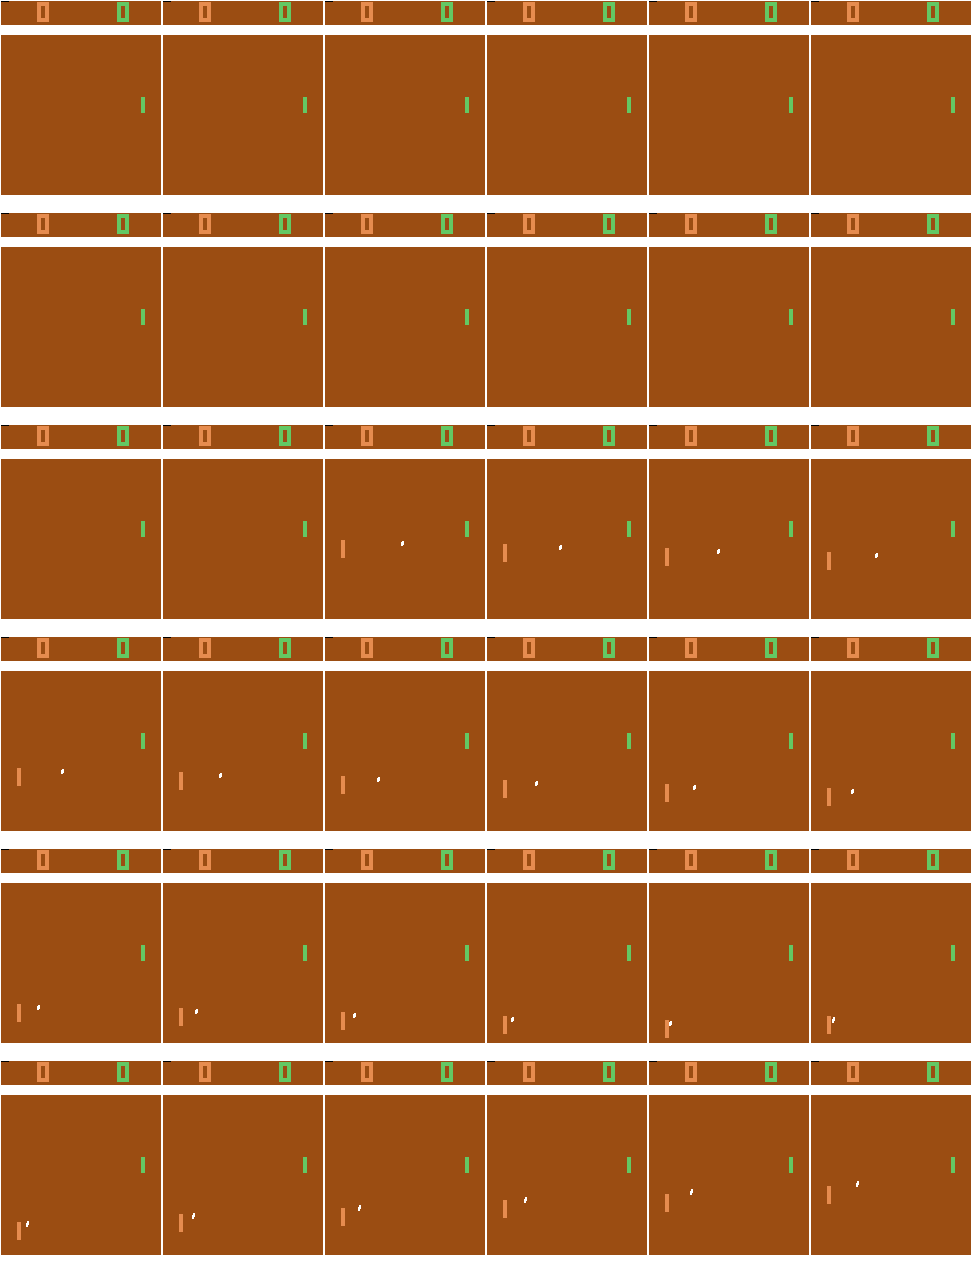

In [8]:
print(game_actions)
screens = {}
for i=1,36 do
    screen, reward, terminal = game_env:step(0)
    table.insert(screens, screen[1]:clone())
end
itorch.image(screens)

In [11]:
agent

dqn.NeuralQLearner
{
  lr_endt : 1000000
  replay_memory : 1000000
  bufferSize : 512
  hist_len : 4
  lr_start : 0.00025
  histType : linear
  bestq : 0
  histSpacing : 1
  deltas : CudaTensor - size: 1685667
  input_dims : 
    {
      1 : 4
      2 : 84
      3 : 84
    }
  n_hid : 
    {
      1 : 512
    }
  ep_start : 1
  q_max : 1
  g : CudaTensor - size: 1685667
  target_network : 
    nn.Sequential {
      [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> output]
      (1): nn.Reshape(4x84x84)
      (2): nn.SpatialConvolution(in: 4, out: 32, kW: 8, kH: 8, dW: 4, dH: 4, padding: 1)
      (3): nn.Rectifier
      (4): nn.SpatialConvolution(in: 32, out: 64, kW: 4, kH: 4, dW: 2, dH: 2)
      (5): nn.Rectifier
      (6): nn.SpatialConvolution(in: 64, out: 64, kW: 3, kH: 3)
      (7): nn.Rectifier
      (8): nn.Reshape(3136)
      (9): nn.Linear(3136 -> 512)
      (10): nn.Rectifier
      (11): nn.Linear(512 -> 3)
    }
    {
      gradInput : C

     nOutputPlane : 32
              output : CudaTensor - size: 1x32x20x20
              gradInput : CudaTensor - empty
              finput : CudaTensor - empty
              kW : 8
              kH : 8
              weight : CudaTensor - size: 32x4x8x8
              nInputPlane : 4
              gradWeight : CudaTensor - size: 32x4x8x8
              padding : 1
              bias : CudaTensor - size: 32
              gradBias : CudaTensor - size: 32
              fgradInput : CudaTensor - empty
            }
          3 : 
            nn.Rectifier
            {
              gradInput : CudaTensor - empty
              output : CudaTensor - size: 1x32x20x20
            }
          4 : 
            nn.SpatialConvolution(in: 32, out: 64, kW: 4, kH: 4, dW: 2, dH: 2)
            {
              dH : 2
              dW : 2
              nOutputPlane : 64
              output : CudaTensor - size: 1x64x9x9
              gradInput : CudaTensor - empty
              finput : CudaTensor - emp

     }
          5 : 
            nn.Rectifier
            {
              gradInput : CudaTensor - empty
              output : CudaTensor - size: 1x64x9x9
            }
          6 : 
            nn.SpatialConvolution(in: 64, out: 64, kW: 3, kH: 3)
            {
              dH : 1
              dW : 1
              nOutputPlane : 64
              output : CudaTensor - size: 1x64x7x7
              gradInput : CudaTensor - empty
              finput : CudaTensor - empty
              kW : 3
              kH : 3
              weight : CudaTensor - size: 64x64x3x3
              nInputPlane : 64
              gradWeight : CudaTensor - size: 64x64x3x3
              padding : 0
              bias : CudaTensor - size: 64
              gradBias : CudaTensor - size: 64
              fgradInput : CudaTensor - empty
            }
          7 : 
            nn.Rectifier
            {
              gradInput : CudaTensor - empty
              output : CudaTensor - size: 1x64x7x7
            }
  

  10 : 
            nn.Rectifier
            {
              gradInput : CudaTensor - empty
              output : CudaTensor - empty
            }
          11 : 
            nn.Linear(512 -> 3)
            {
              gradBias : CudaTensor - size: 3
              weight : CudaTensor - size: 3x512
              bias : CudaTensor - size: 3
              gradInput : CudaTensor - empty
              output : CudaTensor - empty
              gradWeight : CudaTensor - size: 3x512
            }
        }
      output : CudaTensor - empty
    }
  ep_end : 0.1
  g2 : CudaTensor - size: 1685667
  w : CudaTensor - size: 1685667
  update_freq : 4
  minibatch_size : 32
  ncols : 1
  r_max : 1
  transition_params : table: 0x41621680
  lr_end : 0.00025
  target_q : 10000
  numSteps : 0
  v_avg : 0
  n_units : 
    {
      1 : 32
      2 : 64
      3 : 64
    }
  ep_endt : 1000000
  min_reward : -1
  discount : 0.99
  learn_start : 50000
  filter_stride : 
    {
      1 : 4
      2 : 2
      3 :

      histIndices : 
        {
          1 : 1
          2 : 2
          3 : 3
          4 : 4
        }
    }
  max_reward : 1
  wc : 0
  tensor_type : table: 0x40d6f718
  nl : table: 0x41d65620
  actions : 
    {
      1 : 0
      2 : 3
      3 : 4
    }
  n_replay : 1
  nonTermProb : 1
  tmp : CudaTensor - size: 1685667
  network : 
    nn.Sequential {
      [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> output]
      (1): nn.Reshape(4x84x84)
      (2): nn.SpatialConvolution(in: 4, out: 32, kW: 8, kH: 8, dW: 4, dH: 4, padding: 1)
      (3): nn.Rectifier
      (4): nn.SpatialConvolution(in: 32, out: 64, kW: 4, kH: 4, dW: 2, dH: 2)
      (5): nn.Rectifier
      (6): nn.SpatialConvolution(in: 64, out: 64, kW: 3, kH: 3)
      (7): nn.Rectifier
      (8): nn.Reshape(3136)
      (9): nn.Linear(3136 -> 512)
      (10): nn.Rectifier
      (11): nn.Linear(512 -> 3)
    }
    {
      gradInput : CudaTensor - empty
      modules : 
        {
          

         3 : 
            nn.Rectifier
            {
              gradInput : CudaTensor - empty
              output : CudaTensor - size: 1x32x20x20
            }
          4 : 
            nn.SpatialConvolution(in: 32, out: 64, kW: 4, kH: 4, dW: 2, dH: 2)
            {
              dH : 2
              dW : 2
              nOutputPlane : 64
              output : CudaTensor - size: 1x64x9x9
              gradInput : CudaTensor - empty
              finput : CudaTensor - empty
              fgradInput : CudaTensor - empty
              gradBias : CudaTensor - size: 64
              weight : CudaTensor - size: 64x32x4x4
              bias : CudaTensor - size: 64
              gradWeight : CudaTensor - size: 64x32x4x4
              padding : 0
              nInputPlane : 32
              kW : 4
              kH : 4
            }
          5 : 
            nn.Rectifier
            {
              gradInput : CudaTensor - empty
              output : CudaTensor - size: 1x64x9x9
        

              gradWeight : CudaTensor - size: 64x64x3x3
              padding : 0
              nInputPlane : 64
              kW : 3
              kH : 3
            }
          7 : 
            nn.Rectifier
            {
              gradInput : CudaTensor - empty
              output : CudaTensor - size: 1x64x7x7
            }
          8 : 
            nn.Reshape(3136)
            {
              nelement : 3136
              _input : CudaTensor - empty
              output : CudaTensor - empty
              gradInput : CudaTensor - empty
              size : LongStorage - size: 1
              _gradOutput : CudaTensor - empty
              batchsize : LongStorage - size: 2
            }
          9 : 
            nn.Linear(3136 -> 512)
            {
              gradBias : CudaTensor - size: 512
              weight : CudaTensor - size: 512x3136
              bias : CudaTensor - size: 512
              gradInput : CudaTensor - empty
              gradWeight : CudaTensor - size: 

output : CudaTensor - empty
    }
  gpu : 0
  filter_size : 
    {
      1 : 8
      2 : 4
      3 : 3
    }
  lr : 0.00025
  preproc : 
    nn.Scale
    {
      height : 84
      width : 84
    }
  valid_size : 500
  clip_delta : 1
  verbose : 2
  rescale_r : 1
  n_actions : 3
  state_dim : 7056
  dw : CudaTensor - size: 1685667
}


In [ ]:
local learn_start = agent.learn_start
local start_time = sys.clock()
local reward_counts = {}
local episode_counts = {}
local time_history = {}
local v_history = {}
local qmax_history = {}
local td_history = {}
local reward_history = {}
local step = 0
time_history[1] = 0

local total_reward
local nrewards
local nepisodes
local episode_reward


-- When we save agent, there are many temporary states in the agent. The proper way would be to implement 
-- agent:read() and agent:write() functions as in TransitionTable.lua 
-- But using Lua closures, we can also have a nice interface like follows.
-- agent is the agent to make slim so that we do not dump GBs of data
-- returns a deslim function that does not take any arguments and reinstates the parameters in the agent.
local function slim_agent(agent)
    local s, a, r, s2, term = agent.valid_s, agent.valid_a, agent.valid_r,agent.valid_s2, agent.valid_term
    agent.valid_s, agent.valid_a, agent.valid_r, agent.valid_s2, agent.valid_term = nil, nil, nil, nil, nil, nil, nil
    local w, dw, g, g2, delta, delta2, deltas, tmp = agent.w, agent.dw, agent.g, agent.g2, agent.delta, agent.delta2, agent.deltas, agent.tmp
    agent.w, agent.dw, agent.g, agent.g2, agent.delta, agent.delta2, agent.deltas, agent.tmp = nil, nil, nil, nil, nil, nil, nil, nil
    
    -- this function now has pointers to all the local variables here when it was called.
    -- so it can remodify the agent with the correct values. One could call slim_agent with many different
    -- agent instances, and every deslim function would point to the correct context.
    local function deslim()
        agent.valid_s, agent.valid_a, agent.valid_r, agent.valid_s2, agent.valid_term = s, a, r, s2, term
        agent.w, agent.dw, agent.g, agent.g2, agent.delta, agent.delta2, agent.deltas, agent.tmp = w, dw, g, g2, delta, delta2, deltas, tmp
    end
    return deslim
end

local screen, reward, terminal = game_env:getState()

print("Iteration ..", step)
while step < opt.steps do
    step = step + 1
    local action_index = agent:perceive(reward, screen, terminal)

    -- game over? get next game!                                                                                                                      
    if not terminal then
        screen, reward, terminal = game_env:step(game_actions[action_index], true)
    else
        if opt.random_starts > 0 then
            screen, reward, terminal = game_env:nextRandomGame()
        else
            screen, reward, terminal = game_env:newGame()
        end
    end

    if step % opt.prog_freq == 0 then
        assert(step==agent.numSteps, 'trainer step: ' .. step ..
                ' & agent.numSteps: ' .. agent.numSteps)
        print("Training Steps: ", step)
        --agent:report()
        collectgarbage()
    end

    if step%1000 == 0 then collectgarbage() end

    if step % opt.eval_freq == 0 and step > learn_start then

        print('Evaluating')
        screen, reward, terminal = game_env:newGame()

        total_reward = 0
        nrewards = 0
        nepisodes = 0
        episode_reward = 0

        local eval_time = sys.clock()
        for estep=1,opt.eval_steps do
            local action_index = agent:perceive(reward, screen, terminal, true, 0.05)
            -- Play game in test mode (episodes don't end when losing a life)                                                                         
            screen, reward, terminal = game_env:step(game_actions[action_index])

            if estep%1000 == 0 then collectgarbage() end

            -- record every reward                                                                                                                    
            episode_reward = episode_reward + reward
            if reward ~= 0 then
               nrewards = nrewards + 1
            end

            if terminal then
                total_reward = total_reward + episode_reward
                episode_reward = 0
                nepisodes = nepisodes + 1
                screen, reward, terminal = game_env:nextRandomGame()
            end
        end

        eval_time = sys.clock() - eval_time
        start_time = start_time + eval_time
        agent:compute_validation_statistics()
        local ind = #reward_history+1
        total_reward = total_reward/math.max(1, nepisodes)

        if #reward_history == 0 or total_reward > torch.Tensor(reward_history):max() then
            agent.best_network = agent.network:clone()
        end

        if agent.v_avg then
            v_history[ind] = agent.v_avg
            td_history[ind] = agent.tderr_avg
            qmax_history[ind] = agent.q_max
        end
        print("V", v_history[ind], "TD error", td_history[ind], "Qmax", qmax_history[ind])

        reward_history[ind] = total_reward
        reward_counts[ind] = nrewards
        episode_counts[ind] = nepisodes
        time_history[ind+1] = sys.clock() - start_time

        local time_dif = time_history[ind+1] - time_history[ind]

        local training_rate = opt.actrep*opt.eval_freq/time_dif

        print(string.format(
            '\nSteps: %d (frames: %d), reward: %.2f, epsilon: %.2f, lr: %G, ' ..
            'training time: %ds, training rate: %dfps, testing time: %ds, ' ..
            'testing rate: %dfps,  num. ep.: %d,  num. rewards: %d',
            step, step*opt.actrep, total_reward, agent.ep, agent.lr, time_dif,
            training_rate, eval_time, opt.actrep*opt.eval_steps/eval_time,
            nepisodes, nrewards))
    end

    if step % opt.save_freq == 0 or step == opt.steps then
        
        local deslim_agent = slim_agent(agent)

        local filename = opt.name
        if opt.save_versions > 0 then
            filename = filename .. "_" .. math.floor(step / opt.save_versions)
        end
        filename = filename
        torch.save(filename .. ".t7", {agent = agent,
                                model = agent.network,
                                best_model = agent.best_network,
                                reward_history = reward_history,
                                reward_counts = reward_counts,
                                episode_counts = episode_counts,
                                time_history = time_history,
                                v_history = v_history,
                                td_history = td_history,
                                qmax_history = qmax_history,
                                arguments=opt})
        if opt.saveNetworkParams then
            local nets = {network=w:clone():float()}
            torch.save(filename..'.params.t7', nets, 'ascii')
        end
        deslim_agent()
        print('Saved:', filename .. '.t7')
        io.flush()
        collectgarbage()
    end
end



Iteration ..	0	


Training Steps: 	10000	
